In [30]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gensim, scipy, nltk
from collections import Counter
from sklearn.datasets import fetch_20newsgroups
# nltk.download('stopwords')
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
#有中文出现的情况，需要u'内容'


## 数据集探索

In [2]:
train_news = fetch_20newsgroups(subset='train')
test_news = fetch_20newsgroups(subset='test')
print(train_news.data[0])
print(train_news.data[1])
print(train_news.data[2])
print(train_news.data[100])
print(train_news.target_names)
print(train_news.target.shape)
print(test_news.target.shape)

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----





From: guykuo@carson.u.washington.edu (Guy Kuo)
Subject: SI Clock Poll - Final Call
Summary: Final call for SI clock reports
Keywords: SI,acceleration,clock,upgrade
Article-I.D.: shelley.1qvfo9INNc3s
Organization: University of Washington
Lines: 11
NNTP-Posting-Host: carson.u.wa

* 数据集由sklearn导入，已经将其分成了测试集和训练集两部分，其中训练集有11314个样本，测试集有7532个样本，数据集已经分为了20个样本了。
* 每篇样本文档可以看作电子邮件文档，有来信人，正文，结束语等结构

## 新闻数据探索可视化

In [3]:
categories = train_news.target_names
sub_train_news = fetch_20newsgroups(subset='train', categories=categories)
sub_test_news = fetch_20newsgroups(subset='test',categories=categories)

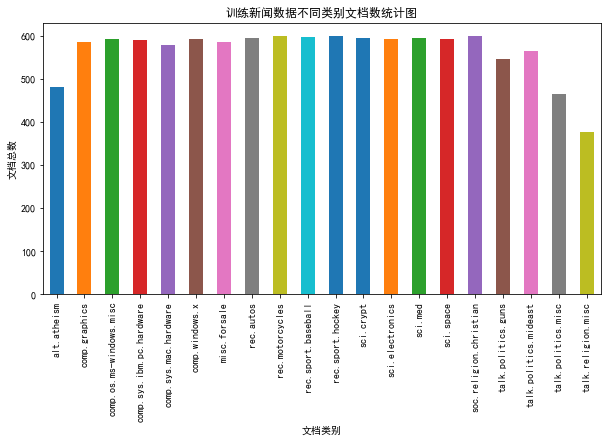

In [4]:
# 观察不同分类的文档数量分布
df = pd.DataFrame(sub_train_news.target, columns=['category'], dtype=np.int8)
sum = df['category'].groupby(df['category']).count()
sum.index = sub_train_news.target_names
sum.plot(kind = 'bar',figsize=(10, 5))
plt.title('训练新闻数据不同类别文档数统计图')
plt.xlabel('文档类别')
plt.ylabel('文档总数')
plt.show()


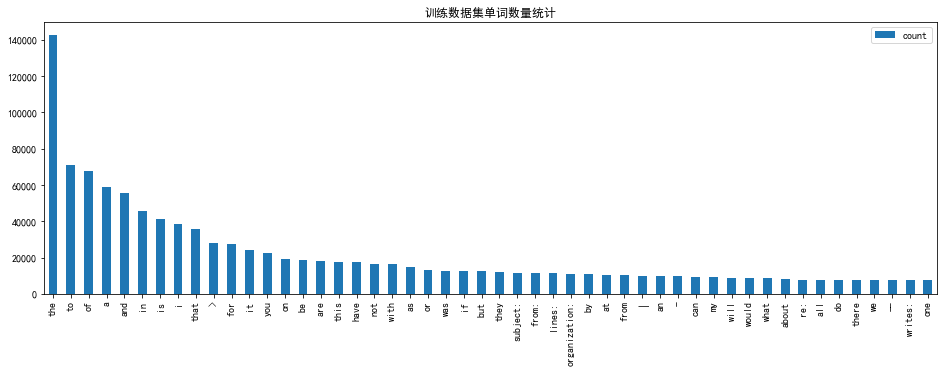

In [5]:
from collections import Counter  
# 将文档分词，并统计不同单词的数量
def get_topN_word(data):
    texts = [[word for word in document.lower().split()]  
              for document in data]  
    
    frequency = {}
    for text in texts:  
        for token in text:  
            if not token in frequency:
                frequency[token] = 0
            frequency[token] += 1
    

    word_counter = Counter(frequency)
    word_counter.most_common(50)
    train_texts_df = pd.DataFrame.from_dict(frequency,orient='index')
    train_texts_df.columns = ['count']
    train_texts_df.sort_values(['count'], ascending=False, inplace=True)
    top_n_words_df = train_texts_df.head(50)
    return top_n_words_df

train_top_n_words = get_topN_word(sub_train_news.data)
train_top_n_words.plot(kind='bar',figsize=(16,5))
plt.title('训练数据集单词数量统计')
plt.show()

# test_top_n_words = get_topN_word(sub_test_news.data)
# test_top_n_words.plot(kind='bar',figsize=(16,5))
# plt.title('测试数据集单词数量统计')
# plt.show()

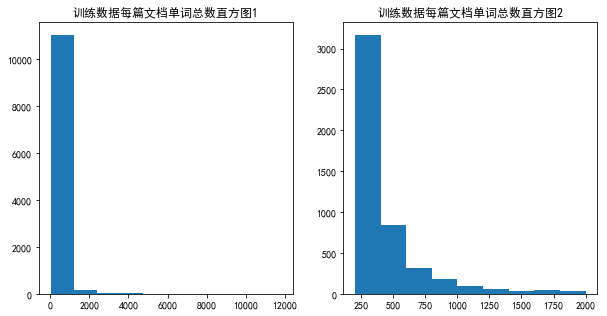

In [6]:
# 统计每篇文档单词总数
def count_doc_words(data):
    texts = [[word for word in document.lower().split()] for document in data]

    for index, text in enumerate(texts):
        texts[index] = len(text)
     
    return texts

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax0, ax1= axes.flatten()
ax0.hist(count_doc_words(sub_train_news.data), 10)
ax0.set_title('训练数据每篇文档单词总数直方图1')


ax1.hist(count_doc_words(sub_train_news.data), [200,400,600,800,1000,1200,1400,1600,1800,2000])
ax1.set_title('训练数据每篇文档单词总数直方图2')
plt.show()

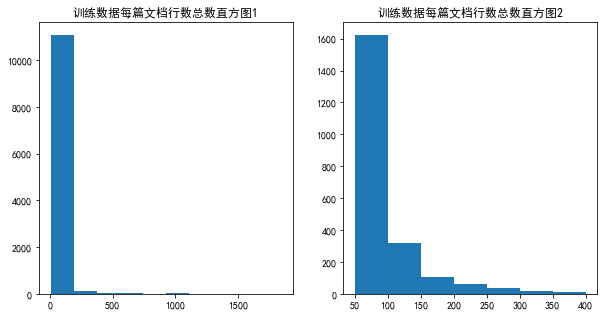

In [7]:
# 统计每篇文档单词总数
def count_doc_lines(data):
    texts = [ len(document.split('\n')) for document in data]
     
    return texts

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax0, ax1= axes.flatten()
ax0.hist(count_doc_lines(sub_train_news.data), 10)
ax0.set_title('训练数据每篇文档行数总数直方图1')
# ax1.hist(count_doc_lines(sub_train_news.data), 10)
# ax1.set_title('测试数据每篇文档行数总数直方图1')

ax1.hist(count_doc_lines(sub_train_news.data), [50,100,150,200,250,300,350,400])
ax1.set_title('训练数据每篇文档行数总数直方图2')
# ax3.hist(count_doc_lines(sub_train_news.data), [50,100,150,200,250,300,350,400])
# ax3.set_title('测试数据每篇文档行数总数直方图2')
plt.show()

In [33]:
categories = ['rec.sport.baseball', 'comp.graphics', 'sci.med', 'soc.religion.christian']
sub_train_news = fetch_20newsgroups(subset='train', categories=categories)
sub_test_news = fetch_20newsgroups(subset='test',categories=categories)

##  新闻文档分词预处理

In [31]:
from gensim.parsing.preprocessing import preprocess_string
from nltk.corpus import stopwords  
def preprocessing_text(data):
    """
    @去除英文停用词,去除单词前后的特殊符号，去除仅出现一次的单词
    """
    texts = []
    for document in data:
        texts.append(preprocess_string(document))

    frequency = {}
    for text in texts:  
        for token in text:  
            if not token in frequency:
                frequency[token] = 0
            frequency[token] += 1

    texts = [[token for token in text if frequency[token] > 1] for text in texts]
    return texts, frequency

def custom_preprocessing_text(data):
   
    english_stopwords = stopwords.words('english')  
    # 数据来源：https://www.ranks.nl/stopwords
    stoplist = [line.lower().strip() for line in open('englist_long_stop_words_v1.txt')]
    english_stopwords.extend(stoplist)
    # 数据来源：http://blog.csdn.net/shijiebei2009/article/details/39696523
    stoplist = [line.lower().strip() for line in open('englist_long_stop_words_v2.txt')]
    english_stopwords.extend(stoplist)
    # 数据来源：http://blog.csdn.net/u014470581/article/details/51598258
    stoplist = [line.lower().strip() for line in open('englist_long_stop_words_v3.txt')]
    english_stopwords.extend(stoplist)
    english_stopwords = list(set(english_stopwords))

    english_punctuations = [',','.',':',';','?','!','(',')','[',']',
                            '@','&','#','%','$','{','}','--','-','_','*','\\','\\\\','/','//','|','||','>','<','+','"',"'",'=','^']

    _excludes = [str(i) for i in range(11)]
    _excludes.extend(english_punctuations)
    _excludes.remove('-')
    _excludes.remove("'")
    
    texts = []
    for document in data:
        _doc = []
        for word in document.lower().split():
           
            while word:
                if word[0] in english_punctuations:
                    word = word.strip(word[0])
                elif word[-1] in english_punctuations:
                    word = word.strip(word[-1])
                else:
                    break
          
            if word and word not in english_stopwords:
                _flag = True
                for s in _excludes:
                    if s in word:
                        _flag = False
                        break
                if _flag:
                    _doc.append(word)
        texts.append(_doc)

    frequency = {}
    for text in texts:  
        for token in text:  
            if not token in frequency:
                frequency[token] = 0
            frequency[token] += 1

    texts = [[token for token in text if frequency[token] > 2] for text in texts]
    return texts, frequency


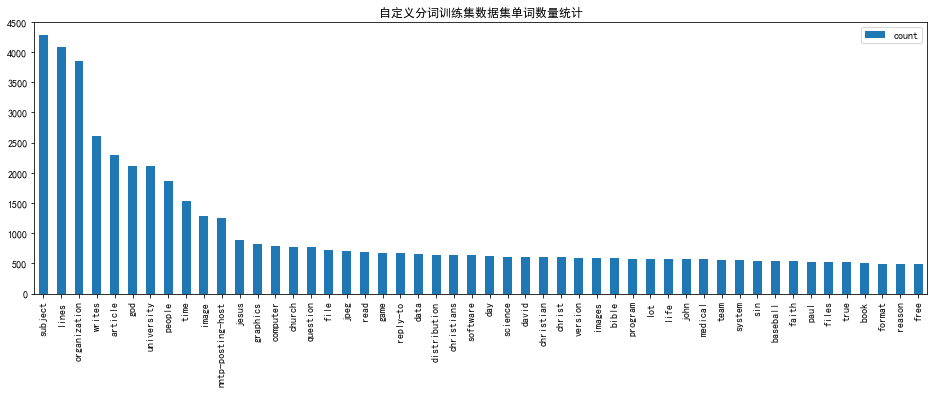

In [34]:
sub_news_data = sub_train_news.data[:]
sub_news_data.extend(sub_test_news.data)

custom_all_sub_texts, custom_sub_all_frequency = custom_preprocessing_text(sub_news_data)
custom_sub_train_texts, custom_train_frequency  = custom_preprocessing_text(sub_train_news.data)
custom_sub_test_texts, custom_test_frequency = custom_preprocessing_text(sub_test_news.data)

custom_train_texts_df = pd.DataFrame.from_dict(custom_sub_all_frequency, orient='index')
custom_train_texts_df.columns = ['count']
custom_train_texts_df.sort_values(['count'], ascending=False, inplace=True)
custom_train_top_n_words = custom_train_texts_df.head(50)
custom_train_top_n_words.plot(kind='bar',figsize=(16,5))
plt.title('自定义分词训练集数据集单词数量统计')

plt.show()


## 保存分词结果

In [35]:
from gensim import corpora, models, similarities
# 保存分词结果
custom_dictionary = corpora.Dictionary(custom_all_sub_texts)  
custom_dictionary.save('corpus_module/custom_texts.dict')
custom_all_corpus = [custom_dictionary.doc2bow(text) for text in custom_all_sub_texts]
corpora.MmCorpus.serialize('corpus_module/custom_texts.mm', custom_all_corpus)
custom_train_corpus = [custom_dictionary.doc2bow(text) for text in custom_sub_train_texts]  
corpora.MmCorpus.serialize('corpus_module/custom_train_texts.mm', custom_train_corpus)
custom_test_corpus = [custom_dictionary.doc2bow(text) for text in custom_sub_test_texts]  
corpora.MmCorpus.serialize('corpus_module/custom_test_texts.mm', custom_test_corpus)


## 文档分类

In [44]:
# 加载语料库
import gensim
from gensim import corpora, models, similarities
from gensim import sklearn_api
from sklearn.datasets import fetch_20newsgroups


categories = ['rec.sport.baseball', 'comp.graphics', 'sci.med', 'soc.religion.christian']
sub_train_news = fetch_20newsgroups(subset='train', categories=categories)
sub_test_news = fetch_20newsgroups(subset='test',categories=categories)

custom_all_corpus = corpora.MmCorpus('corpus_module/custom_texts.mm')
custom_dictionary = corpora.Dictionary.load('corpus_module/custom_texts.dict')
custom_train_corpus = corpora.MmCorpus('corpus_module/custom_train_texts.mm')
custom_test_corpus = corpora.MmCorpus('corpus_module/custom_test_texts.mm')

# 将gensim稀疏矩阵转换为numpy 数组类型
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
len_custom_dict = len(custom_dictionary.token2id)


custom_train_matrix = gensim.matutils.corpus2dense(custom_train_corpus, num_terms=len_custom_dict).T
custom_test_matrix = gensim.matutils.corpus2dense(custom_test_corpus, num_terms=len_custom_dict).T

vectorizer = TfidfTransformer()
custom_train_matrix = vectorizer.fit_transform(custom_train_matrix)
custom_test_matrix = vectorizer.fit_transform(custom_test_matrix)
print('custom dictionary count:{}'.format(len(custom_dictionary)))

custom dictionary count:17407


### SVM model

In [9]:
# SVM with linear kernel 
from sklearn import svm
from sklearn import metrics
import time

clf = svm.SVC(kernel='linear',random_state=8) # 使用线性核
start_time = time.time()
clf_res = clf.fit(custom_train_matrix, sub_train_news.target)
print('total time {}'.format(time.time() - start_time))
test_pred   = clf_res.predict(custom_test_matrix)

custom_svm_score = metrics.f1_score(sub_test_news.target, test_pred, average='macro')
train_pred = clf_res.predict(custom_train_matrix)
train_custom_svm_score = metrics.f1_score(sub_train_news.target, train_pred, average='macro')


# print('the score of gensim svm is {}'.format(gensim_svm_score))
print('the f1 score of test svm is {}'.format(custom_svm_score))
print('the f1 score of train set is {}'.format(train_custom_svm_score))

test_accuracy_score = metrics.accuracy_score(sub_test_news.target, test_pred)
train_accuracy_score = metrics.accuracy_score(sub_train_news.target, train_pred) 
print('the accuracy score of test svm is {}'.format(test_accuracy_score))
print('the accuracy score of train set is {}'.format(train_accuracy_score))


total time 2.0681183338165283
the f1 score of test svm is 0.9587960236339144
the f1 score of train set is 0.999155351820588
the accuracy score of test svm is 0.9588607594936709
the accuracy score of train set is 0.9991575400168492


In [27]:
# GridSearchCV svm
import time
from sklearn import svm
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
params = {'C': [0.001, 0.01, 0.1, 1]}
clf = svm.SVC(kernel='linear',random_state=8) # 使用线性核
gs = GridSearchCV(clf, params, cv=10, scoring='accuracy')
gs.fit(custom_train_matrix, sub_train_news.target)
gs.grid_scores_

[mean: 0.25232, std: 0.00133, params: {'C': 0.001},
 mean: 0.25232, std: 0.00133, params: {'C': 0.01},
 mean: 0.95198, std: 0.01447, params: {'C': 0.1},
 mean: 0.98189, std: 0.00943, params: {'C': 1}]

In [22]:
print(gs.grid_scores_[3].parameters)
print(gs.grid_scores_[3].cv_validation_scores)
print(gs.grid_scores_[3].mean_validation_score)
grid_mean_scores = [result.mean_validation_score for result in gs.grid_scores_]
print(grid_mean_scores)

{'C': 1}
[ 0.9874477   0.9707113   0.9958159   0.9874477   0.97046414  0.99156118
  0.98312236  0.98305085  0.98305085  0.99574468]
0.9848357203032856
[0.9671440606571188, 0.9730412805391744, 0.9797809604043808, 0.9848357203032856]


In [20]:
# LinearSVC
from sklearn import svm
from sklearn import metrics
import time

clf = svm.LinearSVC(random_state=8) # 使用线性核
start_time = time.time()
clf_res = clf.fit(custom_train_matrix, sub_train_news.target)
print('total time {}'.format(time.time() - start_time))
test_pred   = clf_res.predict(custom_test_matrix)

custom_svm_score = metrics.f1_score(sub_test_news.target, test_pred, average='macro')
train_pred = clf_res.predict(custom_train_matrix)
train_custom_svm_score = metrics.f1_score(sub_train_news.target, train_pred, average='macro')


# print('the score of gensim svm is {}'.format(gensim_svm_score))
print('the f1 score of test svm is {}'.format(custom_svm_score))
print('the f1 score of train set is {}'.format(train_custom_svm_score))

test_accuracy_score = metrics.accuracy_score(sub_test_news.target, test_pred)
train_accuracy_score = metrics.accuracy_score(sub_train_news.target, train_pred) 
print('the accuracy score of test svm is {}'.format(test_accuracy_score))
print('the accuracy score of train set is {}'.format(train_accuracy_score))

total time 0.08000445365905762
the f1 score of test svm is 0.9619169430613329
the f1 score of train set is 1.0
the accuracy score of test svm is 0.9620253164556962
the accuracy score of train set is 1.0


### 多项式 Naive Bayes

In [30]:
import time
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

start_time = time.time()
clf = MultinomialNB()
clf.fit(custom_train_matrix, sub_train_news.target)
print('total time {}'.format(time.time() - start_time))
test_pred = clf.predict(custom_test_matrix)
train_pred = clf.predict(custom_train_matrix)

test_f1_score = metrics.f1_score(sub_test_news.target, test_pred, average='macro')
train_f1_score = metrics.f1_score(sub_train_news.target, train_pred, average='macro') 
print('the f1 score of test mnb is {}'.format(test_f1_score))
print('the f1 score of train mnb is {}'.format(train_f1_score))

test_accuracy_score = metrics.accuracy_score(sub_test_news.target, test_pred)
train_accuracy_score = metrics.accuracy_score(sub_train_news.target, train_pred) 
print('the accuracy score of test mnb is {}'.format(test_accuracy_score))
print('the accuracy score of train mnb is {}'.format(train_accuracy_score))


total time 0.005000114440917969
the f1 score of test mnb is 0.952821910918785
the f1 score of train mnb is 0.9949391465983992
the accuracy score of test mnb is 0.9531645569620253
the accuracy score of train mnb is 0.9949452401010952


In [31]:
# GridSearchCV 
import time
from sklearn import svm
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
params = {'alpha': [0.001, 0.01, 0.1, 1]}
clf =  MultinomialNB()
gs = GridSearchCV(clf, params, cv=10, scoring='accuracy')
gs.fit(custom_train_matrix, sub_train_news.target)
gs.grid_scores_


[mean: 0.98484, std: 0.00838, params: {'alpha': 0.001},
 mean: 0.98989, std: 0.00774, params: {'alpha': 0.01},
 mean: 0.98736, std: 0.00724, params: {'alpha': 0.1},
 mean: 0.98273, std: 0.00684, params: {'alpha': 1}]

In [45]:
# alpha = 0.01
start_time = time.time()
clf = MultinomialNB(alpha=.01)
clf.fit(custom_train_matrix, sub_train_news.target)
print('total time {}'.format(time.time() - start_time))
test_pred = clf.predict(custom_test_matrix)
train_pred = clf.predict(custom_train_matrix)

test_f1_score = metrics.f1_score(sub_test_news.target, test_pred, average='macro')
train_f1_score = metrics.f1_score(sub_train_news.target, train_pred, average='macro') 
print('the f1 score of test mnb is {}'.format(test_f1_score))
print('the f1 score of train mnb is {}'.format(train_f1_score))

test_accuracy_score = metrics.accuracy_score(sub_test_news.target, test_pred)
train_accuracy_score = metrics.accuracy_score(sub_train_news.target, train_pred) 
print('the accuracy score of test mnb is {}'.format(test_accuracy_score))
print('the accuracy score of train mnb is {}'.format(train_accuracy_score))

total time 0.0060002803802490234
the f1 score of test mnb is 0.9586605206878345
the f1 score of train mnb is 0.9987330039195134
the accuracy score of test mnb is 0.9588607594936709
the accuracy score of train mnb is 0.9987363100252739


### 前向反馈神经网络

In [2]:
custom_train_matrix = custom_train_matrix.toarray() # 将稀疏矩阵转化为numpy array
custom_test_matrix = custom_test_matrix.toarray() # 将稀疏矩阵转化为numpy array

In [21]:
import tensorflow as tf
import numpy as np

len_custom_dict = len(custom_dictionary.token2id)

def get_batch(df,i,batch_size,target):

    results = []
    texts = df[i*batch_size:i*batch_size+batch_size]
    categories = target[i*batch_size:i*batch_size+batch_size]
        
    for category in categories:
        y = np.zeros((4),dtype=float)
        if category == 0:
            y[0] = 1.
        elif category == 1:
            y[1] = 1.
        elif category == 2:
            y[2] = 1.
        elif category == 3:
            y[3] = 1.
        results.append(y)           
     
    return texts.astype(np.float32), np.array(results).astype(np.float32)


tf.reset_default_graph()
# Parameters
learning_rate = 0.05
training_epochs = 30
batch_size = 100
display_step = 1

# Network Parameters
n_hidden_1 = 3072     # 1st layer number of features
n_hidden_2 = 3072  # 2nd layer number of features
n_input = len_custom_dict # Words in vocab
n_classes = 4         # Categories: graphics, sci.space and baseball

input_tensor = tf.placeholder(tf.float32,[None, n_input],name="input")
output_tensor = tf.placeholder(tf.float32,[None, n_classes],name="output") 
def multilayer_perceptron(input_tensor, weights, biases):
    layer_1_multiplication = tf.matmul(input_tensor, weights['h1'])
    layer_1_addition = tf.add(layer_1_multiplication, biases['b1'])
    layer_1 = tf.nn.relu(layer_1_addition)
    
    # Hidden layer with RELU activation
    layer_2_multiplication = tf.matmul(layer_1, weights['h2'])
    layer_2_addition = tf.add(layer_2_multiplication, biases['b2'])
    layer_2 = tf.nn.relu(layer_2_addition)
    
    # Output layer 
    out_layer_multiplication = tf.matmul(layer_1, weights['out'])
    out_layer_addition = out_layer_multiplication + biases['out']
    
    return out_layer_addition

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Construct model
prediction = multilayer_perceptron(input_tensor, weights, biases)

# Define loss and optimizer
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=output_tensor))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# Initializing the variables
init = tf.global_variables_initializer()

In [22]:
import time
from sklearn import metrics
loss_data = []
acc_data = []
train_acc_data = []
# Launch the graph
with tf.Session() as sess:
    sess.run(init)

    # Training cycle
    start_time = time.time()

    batch_x_train,batch_y_train = get_batch(custom_train_matrix,0,len(sub_train_news.data),sub_train_news.target)
    total_test_data = len(sub_test_news.data)
    batch_x_test,batch_y_test = get_batch(custom_test_matrix,0,total_test_data, sub_test_news.target)
 
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(len(sub_train_news.data)/ batch_size)
        # Loop over all batches
        for i in range(total_batch):
#             batch_x,batch_y = get_batch(newsgroups_train,i,batch_size)
            batch_x,batch_y = get_batch(custom_train_matrix,i,batch_size,sub_train_news.target)
         
            # Run optimization op (backprop) and cost op (to get loss value)
            val_loss,val_acc = sess.run([loss,optimizer], feed_dict={input_tensor: batch_x,output_tensor:batch_y})
            # Compute average loss
            avg_cost += val_loss / total_batch
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "loss=", \
                "{:.9f}".format(avg_cost))
     
        correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(output_tensor, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        loss_data.append(avg_cost)
        acc_data.append(accuracy.eval({input_tensor: batch_x_test, output_tensor: batch_y_test}))
        train_acc_data.append(accuracy.eval({input_tensor: batch_x_train, output_tensor: batch_y_train}))

    print('total time {}'.format(time.time() - start_time))
    print("Optimization Finished!")
    # Test model
    correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(output_tensor, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Accuracy:", accuracy.eval({input_tensor: batch_x_test, output_tensor: batch_y_test}))
    print("Train Accuracy:", accuracy.eval({input_tensor: batch_x_train, output_tensor: batch_y_train}))
    
    #metrics
    y_p = tf.argmax(prediction, 1)
    val_accuracy, y_pred = sess.run([accuracy, y_p], feed_dict={input_tensor:batch_x_test, output_tensor:batch_y_test})

    y_true = np.argmax(batch_y_test,1)
    print("Precision", metrics.precision_score(y_true, y_pred, average='macro'))
    print( "Recall", metrics.recall_score(y_true, y_pred, average='macro'))
    print( "f1_score", metrics.f1_score(y_true, y_pred, average='macro'))



Epoch: 0001 loss= 24.177479008
Epoch: 0002 loss= 0.806768425
Epoch: 0003 loss= 0.113358098
Epoch: 0004 loss= 0.010200693
Epoch: 0005 loss= 0.000000000
Epoch: 0006 loss= 0.000000000
Epoch: 0007 loss= 0.000000000
Epoch: 0008 loss= 0.000000000
Epoch: 0009 loss= 0.000000000
Epoch: 0010 loss= 0.000000000
Epoch: 0011 loss= 0.000000000
Epoch: 0012 loss= 0.000000000
Epoch: 0013 loss= 0.000000000
Epoch: 0014 loss= 0.000000000
Epoch: 0015 loss= 0.000000000
Epoch: 0016 loss= 0.000000000
Epoch: 0017 loss= 0.000000000
Epoch: 0018 loss= 0.000000000
Epoch: 0019 loss= 0.000000000
Epoch: 0020 loss= 0.000000000
Epoch: 0021 loss= 0.000000000
Epoch: 0022 loss= 0.000000000
Epoch: 0023 loss= 0.000000000
Epoch: 0024 loss= 0.000000000
Epoch: 0025 loss= 0.000000000
Epoch: 0026 loss= 0.000000000
Epoch: 0027 loss= 0.000000000
Epoch: 0028 loss= 0.000000000
Epoch: 0029 loss= 0.000000000
Epoch: 0030 loss= 0.000000000
total time 109.49326276779175
Optimization Finished!
Accuracy: 0.93481
Train Accuracy: 0.998736
Pre

In [ ]:
print(loss_data)
print(acc_data)
print(train_acc_data)

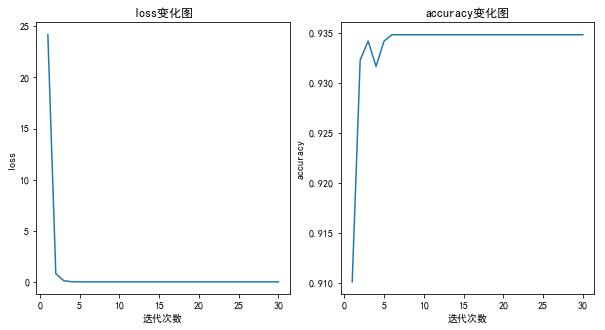

In [23]:
import matplotlib.pyplot as plt  
  
x1 = range(1, training_epochs + 1)
y1= loss_data
  
x2 = x1
y2= acc_data

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax0, ax1= axes.flatten()
ax0.plot(x1,y1)
ax0.set_title('loss变化图')
ax0.set_xlabel('迭代次数')
ax0.set_ylabel('loss')
ax1.plot(x2, y2)
ax1.set_title('accuracy变化图')
ax1.set_xlabel('迭代次数')
ax1.set_ylabel('accuracy')
plt.show()

['graphics', 'lines', 'subject', 'university', 'nntp-posting-host', 'organization', 'files', 'image']
['baseball', 'team', 'game', 'players', 'writes', 'games', 'organization', 'subject']
['gordon', 'banks', 'msg', 'article', 'science', 'writes', 'subject', 'organization']
['god', 'jesus', 'people', 'church', 'christians', 'bible', 'christian', 'faith']
['comp.graphics', 'rec.sport.baseball', 'sci.med', 'soc.religion.christian']


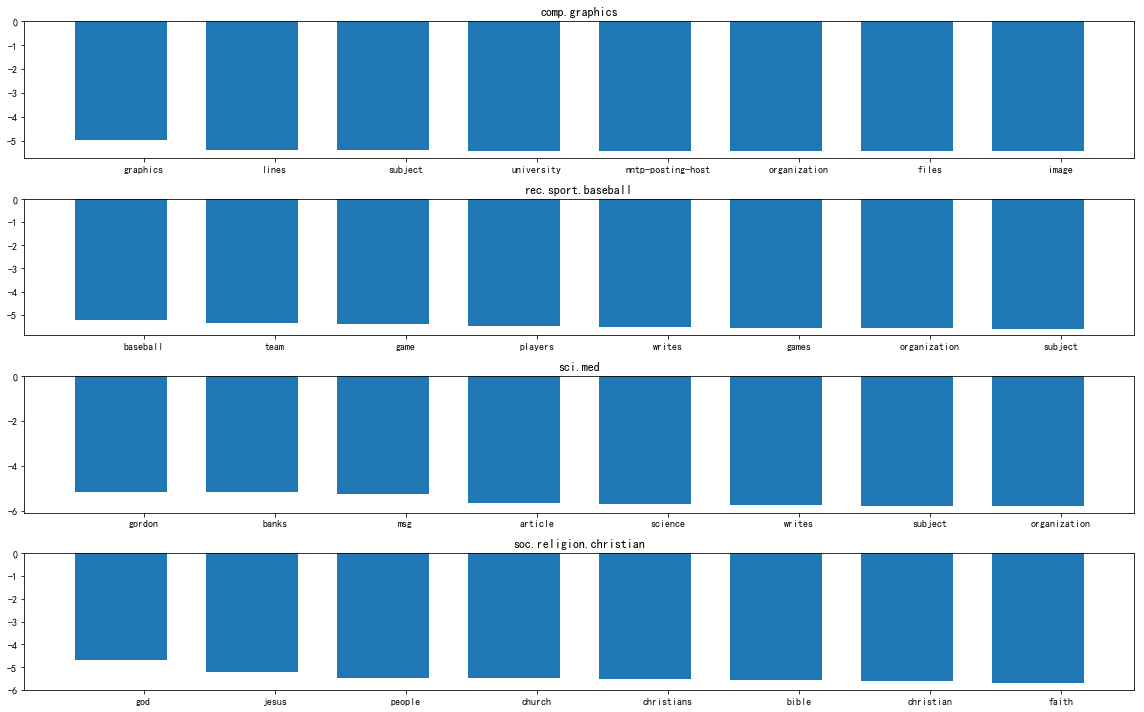

In [169]:
# 单次贡献率
id2token = { v:k for k, v in custom_dictionary.token2id.items() }
clf.feature_log_prob_[0]
def getTopFeatures(features):
    sorted_features = sorted(features, reverse=True)
    return sorted_features[:8]

top_1 = getTopFeatures(clf.feature_log_prob_[0])
top_2 = getTopFeatures(clf.feature_log_prob_[1])
top_3 = getTopFeatures(clf.feature_log_prob_[2])
top_4 = getTopFeatures(clf.feature_log_prob_[3])

def getTopWords(top_features, clf_features, id2token):
    res = []
    for v in top_features:
        i = list(clf_features).index(v)
        res.append(id2token[i])
    return res
    
top_1_words = getTopWords(top_1, clf.feature_log_prob_[0], id2token)
top_2_words = getTopWords(top_2, clf.feature_log_prob_[1], id2token) 
top_3_words = getTopWords(top_3, clf.feature_log_prob_[2], id2token) 
top_4_words = getTopWords(top_4, clf.feature_log_prob_[3], id2token)
print(top_1_words)
print(top_2_words)
print(top_3_words)
print(top_4_words)
print(sub_test_news.target_names)
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(16, 10))
width = 0.4
ind = np.linspace(2,10,8)

ax0, ax1, ax2, ax3= axes.flatten()
ax0.bar(ind-width/2, top_1)
ax0.set_title(sub_test_news.target_names[0])
ax0.set_xticks(ind)
ax0.set_xticklabels(top_1_words)

ax1.bar(ind-width/2, top_2)
ax1.set_title(sub_test_news.target_names[1])
ax1.set_xticks(ind)
ax1.set_xticklabels(top_2_words)

ax2.bar(ind-width/2, top_3)
ax2.set_title(sub_test_news.target_names[2])
ax2.set_xticks(ind)
ax2.set_xticklabels(top_3_words)

ax3.bar(ind-width/2, top_4)
ax3.set_title(sub_test_news.target_names[3])
ax3.set_xticks(ind)
ax3.set_xticklabels(top_4_words)

fig.tight_layout()
plt.show()